# Building the simplest Graph

We start with a graph with two nodes connected by one edge.


In [1]:
!pip install  -qU langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.8 MB/s eta 0:00:00


Nodes act like functions that can be called as needed. In our case Node 1 is our starting point and Node 2 is our finish point.

# **Nodes**
Nodes are just python functions.


In [2]:
def function_1(input_1):
    return input_1 + " I am "

def function_2(input_2):
    return input_2 + "happy"

# **Edges**
Edges connect the nodes.

Normal Edges are used if you want to always go from, for example, node_1 to node_2.

In [3]:
from langgraph.graph import Graph, START, END

# Define a graph
workflow = Graph()

# define nodes
workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

# define edges
workflow.add_edge(START, 'node_1')
workflow.add_edge('node_1', 'node_2')
workflow.add_edge('node_2', END)

graph = workflow.compile()

In [4]:
print(graph)
print(type(graph))

<class 'langgraph.graph.graph.CompiledGraph'>


In [5]:
print(graph.get_graph())

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langgraph.graph.graph.LangGraphInput'>, metadata=None), 'node_1': Node(id='node_1', name='node_1', data=node_1(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'node_2': Node(id='node_2', name='node_2', data=node_2(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'langgraph.graph.graph.LangGraphOutput'>, metadata=None)}, edges=[Edge(source='__start__', target='node_1', data=None, conditional=False), Edge(source='node_1', target='node_2', data=None, conditional=False), Edge(source='node_2', target='__end__', data=None, conditional=False)])


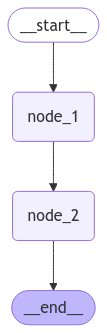

In [6]:
from IPython.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Executing a LangGraph: The Runnable Protocol

When a LangGraph is compiled, it **implements the Runnable Protocol**.  
This means it follows a **standardized way** of execution in LangChain.

### 🔹 What is the Runnable Protocol?
It defines methods to run LangChain components, including:
- `.invoke(input)`: Runs the component with an input and returns the result.
- `.stream(input)`: Streams the output in real-time.

### 🔹 Why is this important?
Since the compiled graph follows this protocol, we can execute it just like other LangChain components.

### 🔹 Example Usage
```python
output = graph.invoke(input)
print(output)


In [7]:
graph.invoke("Hello")

'Hello I am happy'

**invoke** runs the entire graph synchronously.

This waits for each step to complete before moving to the next.

It returns the final state of the graph after all nodes have executed

In [8]:
input = 'Hello'
for output in graph.stream(input):
    # print(output)

    for key,value in output.items():
      # print(item)
        print(f"Output from node '{key}':")
        print("---")
        print(value)

    print("\n---\n")

Output from node 'node_1':
---
Hello I am 

---

Output from node 'node_2':
---
Hello I am happy

---



### As you can see, we can run the nodes as functions and return some values from them.



# Adding LLM Call

Now, let's make the first node as an "Agent" that can call Open AI models. We can use langchain to make this call easy for us.

In [9]:
!pip install -qU langchain langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 29.8 MB/s eta 0:00:00


In [10]:
# access environment variables

from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize an instance of the ChatGoogleGenerativeAI with specific parameters
model: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    # model="gemini-1.5-flash",  # Specify the model to use
    model="gemini-2.0-flash-exp",
    api_key=gemini_api_key    # Provide the Google API key for authentication
)

In [12]:
#Call the model with a user message
response = model.invoke('Hey there')
response

AIMessage(content='Hey! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-18a31962-bb85-49e2-b479-ebd78c33f89a-0', usage_metadata={'input_tokens': 2, 'output_tokens': 10, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [13]:
response = model.invoke('Hey there')
response.content

'Hey! How can I help you today?'

Cool! Keeping that in mind, let's change the function 1 above so that we can send the user question to the model. Then we will send this response to function 2, which will add a short string and return to the user.

In [14]:
def function_1(input_1):
    response = model.invoke(input_1)
    return response.content

def function_2(input_2):
    return "Agent Says: " + input_2

In [15]:
from langgraph.graph import Graph, START, END

# Define a graph
workflow = Graph()

# define nodes
workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

# define edges
workflow.add_edge(START, 'node_1')
workflow.add_edge('node_1', 'node_2')
workflow.add_edge('node_2', END)

graph = workflow.compile()

In [ ]:
from IPython.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
graph.invoke("Hey there")

'Agent Says: Hey! How can I help you today?'

In [17]:
# just a helpter function
import textwrap
from IPython.display import display, Markdown

def to_markdown(text)-> Markdown:
    text : str = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

In [18]:
response  = graph.invoke("Motivate me to learn agentic ai")

# print(response)
to_markdown(response)

> Agent Says: Okay, let's get you fired up about learning Agentic AI! Here's a motivational cocktail, blending the potential, the impact, and the sheer coolness of this emerging field:
> 
> **1. The Future is Autonomous (and You Can Build It):**
> 
> *   **Imagine:** AI that doesn't just passively respond to commands, but proactively tackles complex problems, learns from its mistakes, and achieves goals independently.  That's the promise of agentic AI. It's not just a "nice-to-have" feature; it's a fundamental shift in how we interact with and leverage AI.  **By learning Agentic AI, you're positioning yourself at the forefront of this technological revolution.**
> *   **Solve Real-World Problems:** Think about automating scientific discovery, optimizing complex supply chains, personalizing education at scale, or creating truly intelligent personal assistants.  Agentic AI can tackle problems that are currently too complex or time-consuming for humans alone.  **You can be the one to build solutions that have a tangible and positive impact on the world.**
> 
> **2. Unlock Limitless Career Opportunities:**
> 
> *   **High Demand, Low Supply:** The skills to build, deploy, and manage agentic AI systems are in incredibly high demand.  As companies across industries recognize the potential, they're scrambling for talent.  **Learning Agentic AI gives you a competitive edge and opens doors to exciting and lucrative career paths.**
> *   **Shape the Industry:** This field is still nascent, meaning there's ample opportunity to define best practices, contribute to open-source projects, and become a thought leader.  **You can be a pioneer, shaping the future of Agentic AI and influencing its development.**
> *   **Diverse Roles:**  Whether you're interested in research, development, engineering, product management, or entrepreneurship, Agentic AI offers a wide range of roles to suit your skills and interests.
> 
> **3. The Sheer Intellectual Challenge and Fun:**
> 
> *   **Cutting-Edge Technology:** You'll be working with the latest advancements in AI, including large language models (LLMs), reinforcement learning, planning algorithms, and more. **It's a constant learning experience that will keep your mind engaged and challenged.**
> *   **Creative Problem-Solving:**  Building agentic AI systems requires creative problem-solving.  You'll be designing architectures, defining goals, and developing strategies to enable AI to act autonomously and achieve its objectives.  **It's like building a digital mind, which is incredibly rewarding.**
> *   **Tangible Results:**  Seeing an AI agent successfully navigate a complex environment or solve a challenging problem is incredibly satisfying.  **You'll get to witness the power of your creations in action.**
> 
> **4. Breaking Down the Intimidation Factor:**
> 
> *   **Start Small, Grow Big:** You don't need to become an expert overnight. Start with the fundamentals, focus on a specific application, and gradually expand your knowledge. **There are plenty of resources available to guide you on your journey.**
> *   **Community Support:** The Agentic AI community is growing rapidly.  You'll find plenty of online forums, tutorials, and open-source projects to help you learn and connect with other enthusiasts.  **You're not alone on this journey!**
> *   **Focus on Practical Application:** Don't get bogged down in theory.  Focus on building simple agents and experimenting with different techniques. **Hands-on experience is the best way to learn and solidify your understanding.**
> 
> **Here's a concrete action plan to get you started:**
> 
> 1.  **Define Your "Why":**  What specific problem do you want to solve with Agentic AI?  Having a clear goal will keep you motivated.
> 2.  **Start with the Basics:**  Learn the fundamentals of AI, machine learning, and programming (Python is a great choice).
> 3.  **Explore LLMs:** Dive into the world of Large Language Models (LLMs) like GPT-3, GPT-4, or open-source alternatives. Understand how they can be used as the "brain" of an agent.
> 4.  **Study Agentic AI Frameworks:**  Explore frameworks like LangChain, AutoGPT, or BabyAGI to understand how to structure your agentic systems.
> 5.  **Build a Simple Agent:**  Start with a small project, like an agent that can summarize articles or answer questions about a specific topic.
> 6.  **Join the Community:**  Engage with other learners and experts in online forums, attend webinars, and contribute to open-source projects.
> 7.  **Stay Curious:**  Keep up with the latest research and developments in Agentic AI.
> 
> **Final thought:**  Agentic AI is not just a technology; it's a paradigm shift.  By learning it, you're not just acquiring a skill; you're investing in your future and positioning yourself to be a leader in the age of intelligent machines.  **Go build something amazing!**

In [19]:
input = 'Hey there'
for output in graph.stream(input):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'node_1':
---
Hey! How's it going? What can I help you with today?

---

Output from node 'node_2':
---
Agent Says: Hey! How's it going? What can I help you with today?

---



# First functional Agent App - City Temperature

### Step 1: Parse the city mentioned
Let's extract the city that a user mentions in a query

In [20]:
def function_1(input_1):
    complete_query = "Your task is to provide only the city name based on the user query. \
        Nothing more, just the city name mentioned. Following is the user query: " + input_1
    response = model.invoke(complete_query)
    return response.content

def function_2(input_2):
    return "Agent Says: " + input_2

In [21]:
from langgraph.graph import Graph, START, END

# Define a graph
workflow = Graph()

# define nodes
workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

# define edges
workflow.add_edge(START, 'node_1')
workflow.add_edge('node_1', 'node_2')
workflow.add_edge('node_2', END)

graph = workflow.compile()

In [ ]:
from IPython.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
graph.invoke("What's the temperature in Peshawar")

'Agent Says: Peshawar'

### Step 2: Adding a weather API call

What if we want the function 2 to take the city name and give us the weather for that city.

Well we know that Open Weather Map is [integrated](https://python.langchain.com/docs/integrations/tools/openweathermap) into LangChain

We need to install pyown, create an API key on the website of Open Weather Map (which takes a few hours to activate) and then run the cells below to get weather of a given city.

In [23]:
!pip install -qU pyowm langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.4 MB/s eta 0:00:00


In [24]:
from google.colab import userdata
openweathermap_api_key = userdata.get('OPENWEATHERMAP_API_KEY')

In [25]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper


weather = OpenWeatherMapAPIWrapper(openweathermap_api_key=openweathermap_api_key)

In [26]:
weather_data = weather.run("London")
print(weather_data)

In London, the current weather is as follows:
Detailed status: overcast clouds
Wind speed: 2.57 m/s, direction: 20°
Humidity: 85%
Temperature: 
  - Current: 4.99°C
  - High: 5.63°C
  - Low: 4.45°C
  - Feels like: 2.83°C
Rain: {}
Heat index: None
Cloud cover: 100%


Now, let's integrate this into function 2 and call the function two as a "tool" or "weather_agent" instead of "node_2" in our workflow.

In [27]:
def function_1(input_1):
    complete_query = "Your task is to provide only the city name based on the user query. \
        Nothing more, just the city name mentioned. Following is the user query: " + input_1
    response = model.invoke(complete_query)
    return response.content

def function_2(input_2):
    weather_data = weather.run(input_2)
    return weather_data

In [28]:
from langgraph.graph import Graph, START, END

# Define a graph
workflow = Graph()

# define nodes
workflow.add_node("node_1", function_1)
workflow.add_node("weather_agent", function_2)

# define edges
workflow.add_edge(START, 'node_1')
workflow.add_edge('node_1', 'weather_agent')
workflow.add_edge('weather_agent', END)

graph = workflow.compile()

In [ ]:
from IPython.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
to_markdown(graph.invoke("What's the temperature in Las Vegas"))

> In Las Vegas, the current weather is as follows:
> Detailed status: few clouds
> Wind speed: 4.12 m/s, direction: 70°
> Humidity: 23%
> Temperature: 
>   - Current: 5.21°C
>   - High: 7.03°C
>   - Low: 3.88°C
>   - Feels like: 2.05°C
> Rain: {}
> Heat index: None
> Cloud cover: 20%

In [30]:
input = "What's the temperature in Las Vegas"
for output in graph.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'node_1':
---
Las Vegas

---

Output from node 'weather_agent':
---
In Las Vegas, the current weather is as follows:
Detailed status: few clouds
Wind speed: 4.12 m/s, direction: 70°
Humidity: 23%
Temperature: 
  - Current: 5.21°C
  - High: 7.03°C
  - Low: 3.88°C
  - Feels like: 2.05°C
Rain: {}
Heat index: None
Cloud cover: 20%

---



### Step 3 Adding another LLM Call to filter results

What if we only want the temperature? But current setup gives us the full weather report.

Well we can make another LLM call to filter data

In [31]:
def function_3(input_3):
    complete_query = "Your task is to provide info concisely based on the user query. Following is the user query: " + "user input"
    response = model.invoke(complete_query)
    return response.content

But the issue is the user input is not available from node 2.

Can we pass user input all along from first node to the last?

Yes, we can use a dictionary and pass it between nodes (we could also use just a list, but dict makes it a bit easier)

In [32]:
# assign AgentState as an empty dict
AgentState = {}

# messages key will be assigned as an empty array. We will append new messages as we pass along nodes.
AgentState["messages"] = []

In [33]:
AgentState

{'messages': []}

Our goal is to have this state filled as:
{'messages': [HumanMessage, AIMessage, ...]]}

Also now we need to modify our functions to pass info along the new AgentState

In [34]:
def function_1(state):
    messages = state['messages']
    user_input = messages[-1]
    complete_query = "Your task is to provide only the city name based on the user query. \
                    Nothing more, just the city name mentioned. Following is the user query: " + user_input
    response = model.invoke(complete_query)
    state['messages'].append(response.content) # appending AIMessage response to the AgentState
    return state

def function_2(state):
    messages = state['messages']
    agent_response = messages[-1]
    weather = OpenWeatherMapAPIWrapper(openweathermap_api_key=openweathermap_api_key)
    weather_data = weather.run(agent_response)
    state['messages'].append(weather_data)
    return state

def function_3(state):
    messages = state['messages']
    user_input = messages[0]
    available_info = messages[-1]
    agent2_query = "Your task is to provide info concisely based on the user query and the available information from the internet. \
                        Following is the user query: " + user_input + " Available information: " + available_info
    response = model.invoke(agent2_query)
    return response.content


In [35]:
from langgraph.graph import Graph, START, END

# Define a graph
workflow = Graph()

# define nodes
workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)
workflow.add_node("responder",function_3)

# define edges
workflow.add_edge(START, 'agent')
workflow.add_edge('agent', 'tool')
workflow.add_edge('tool', 'responder')
workflow.add_edge('responder', END)

graph = workflow.compile()

In [ ]:
from IPython.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
# graph.invoke("what is the temperature in las vegas")

In [37]:
inputs = {"messages": ["what is the temperature in las vegas"]}
graph.invoke(inputs)

'The current temperature in Las Vegas is 5.18°C, with a high of 7.03°C and a low of 3.88°C. It feels like 2.01°C.'

In [38]:
input = {"messages": ["what is the temperature in las vegas"]}
for output in graph.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': ['what is the temperature in las vegas', 'Las Vegas']}

---

Output from node 'tool':
---
{'messages': ['what is the temperature in las vegas', 'Las Vegas', 'In Las Vegas, the current weather is as follows:\nDetailed status: few clouds\nWind speed: 4.12 m/s, direction: 70°\nHumidity: 23%\nTemperature: \n  - Current: 5.18°C\n  - High: 7.03°C\n  - Low: 3.88°C\n  - Feels like: 2.01°C\nRain: {}\nHeat index: None\nCloud cover: 20%']}

---

Output from node 'responder':
---
The current temperature in Las Vegas is 5.18°C, with a high of 7.03°C and a low of 3.88°C. It feels like 2.01°C.

---



# **State**
- First, define the State of the graph.

- The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the TypedDict class from python's typing module as our schema, which provides type hints for the keys.

As we notice that there is a lot of appending to the array going on, we can make it a bit easier with the following:

```bash
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


It basically makes the state dictionary as saw previously, and also makes sure that any new message is appended to the messages array when we do the following:
```bash
{"messages": [new_array_element]}
```


##### We also realize that our app is not capable of answering simple questions like "how are you?"

In [39]:
inputs = {"messages": ["hello"]}
graph.invoke(inputs)

NotFoundError: Unable to find the resource

This is because we always want to parse a city and then find the weather.

We can make our agent smarter by saying only use the tool when needed, if not just respond back to the user.

The way we can do this LangGraph is:
1. binding a tool to the agent
2. adding a conditional edge to the agent with the option to either call the tool or not
3. defining the criteria for the conditional edge as when to call the tool. We will define a function for this.


Let's start with the AgentState definition as mentioned a few cells above.

In [56]:
from typing import TypedDict, Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


# Define a custom TypedDict that includes a list of messages with add_messages reducer
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Binding tool with agent (LLM Model) is made easy in langchain

In [86]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_core.tools import tool

# Initialize an instance of the ChatGoogleGenerativeAI with specific parameters
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    # model="gemini-1.5-flash",  # Specify the model to use
    model="gemini-2.0-flash-exp",
    api_key=gemini_api_key    # Provide the Google API key for authentication
)


weather = OpenWeatherMapAPIWrapper(openweathermap_api_key=openweathermap_api_key)

@tool
def get_weather(city: str):
    """Get the current weather in a given city.

    Args:
        city: The city to get the weather for.

    Returns:
        The current weather in the given city.
    """
    return weather.run(city)

In [87]:
tools = [get_weather]
llm_with_tool = llm.bind_tools(tools)

In [88]:
llm_with_tool.invoke("What is the temperature in Peshawar")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city": "Peshawar"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-70424d00-1665-444e-858c-6c2984d3ce31-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'Peshawar'}, 'id': '6f207715-db57-438c-89de-54a49d59980f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 50, 'output_tokens': 6, 'total_tokens': 56, 'input_token_details': {'cache_read': 0}})

Our modified function_1 now becomes as below. The reason is, we are passing the human message as state and appending response to the state. Also, our agent now has a tool bound to it, that it can use.

In [89]:
def function_1(state: AgentState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

Now make a tool node

In [113]:
from langgraph.prebuilt import ToolNode

tools = [get_weather]

function_2 = ToolNode(tools)

Now with all of the changes above, our LangGraph app is modified as below:

In [114]:
# from langgraph.graph import Graph, END

# workflow = Graph()

# Or you could import StateGraph and pass AgentState to it
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.graph.state import CompiledStateGraph

workflow = StateGraph(AgentState)

workflow.add_node("agent", function_1)
workflow.add_node("tools", function_2)

# The conditional edge requires the following info below.
# First, we define the start node. We use `agent`.
# This means these are the edges taken after the `agent` node is called.
# Next, we pass in the function that will determine which node is called next, in our case where_to_go().

workflow.add_edge(START, 'agent')

# We now add a conditional edge from `agent` to `tool`.
workflow.add_conditional_edges(
                "agent",
                # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
                # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
                tools_condition
                )

# We now add a normal edge from `tools` to `agent`.
# This means that if `tool` is called, then it has to call the 'agent' next.
workflow.add_edge('tools', END)

# Basically, agent node has the option to call a tool node based on a condition,
# whereas tool node must call the agent in all cases based on this setup.


graph : CompiledStateGraph = workflow.compile()

We also pass the first message using HumanMessage component available in langchain, makes it easy to differentiate from AIMessage, and FunctionMessage

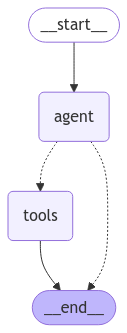

In [115]:
from IPython.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [118]:
# # just another helpter function
# import textwrap
# from IPython.display import display, Markdown
# from langchain.schema import messages

# def to_markdown(state)-> Markdown:
#     # Extract the content of the last message
#     last_message = state['messages'][-1]

#     # If the message has a content attribute, use that, else handle gracefully
#     text = last_message.content

#     text = text.replace("•", "  *")
#     return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

In [122]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the temperature in Lahore")]}
# to_markdown(graph.invoke(inputs))
graph.invoke(inputs)

{'messages': [HumanMessage(content='what is the temperature in Lahore', additional_kwargs={}, response_metadata={}, id='c076c4e7-c9d3-4362-9b1f-db5b75147f07'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city": "Lahore"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-6081ed9e-b9b8-4802-b9b4-e2bb221765bd-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'Lahore'}, 'id': 'e416afc7-6c65-423c-a020-af296511c4ac', 'type': 'tool_call'}], usage_metadata={'input_tokens': 50, 'output_tokens': 6, 'total_tokens': 56, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='In Lahore, the current weather is as follows:\nDetailed status: smoke\nWind speed: 0 m/s, direction: 0°\nHumidity: 71%\nTemperature: \n  - Current: 12.99°C\n  - High: 12.99°C\n  - Low: 12.99°C\n  - Feels like: 12.2°C\nRain: {}\nHeat index: None\nCloud cover: 50%', 

In [123]:
inputs = {"messages": [HumanMessage(content="what is the temperature in las vegas")]}
for output in graph.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city": "las vegas"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-bd0c303e-f6c3-4cac-bf31-453060048ca6-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'las vegas'}, 'id': '149e38b4-67be-4795-8055-cf67abea79ed', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_tokens': 6, 'total_tokens': 57, 'input_token_details': {'cache_read': 0}})]}

---

Output from node 'tools':
---
{'messages': [ToolMessage(content='In las vegas, the current weather is as follows:\nDetailed status: clear sky\nWind speed: 2.06 m/s, direction: 0°\nHumidity: 17%\nTemperature: \n  - Current: 10.28°C\n  - High: 11.82°C\n  - Low: 8.69°C\n  - Feels like: 7.81°C\nRain: {}\nHeat index: None\nCloud cover: 0%', name='get_weather', id='9c28c2c1-ba9f-4b86-a720-8fe4444

# Agent

## Review

We built a router.

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## Goals

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.

But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools.

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [140]:
# from langgraph.graph import Graph, END

# workflow = Graph()

# Or you could import StateGraph and pass AgentState to it
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.state import CompiledStateGraph

workflow = StateGraph(AgentState)

tools = [get_weather]
workflow.add_node("agent", function_1)
workflow.add_node("tools", ToolNode(tools))

# The conditional edge requires the following info below.
# First, we define the start node. We use `agent`.
# This means these are the edges taken after the `agent` node is called.
# Next, we pass in the function that will determine which node is called next, in our case where_to_go().

workflow.add_edge(START, 'agent')

# We now add a conditional edge from `agent` to `tool`.
workflow.add_conditional_edges(
                "agent",
                # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
                # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
                tools_condition
                )

# We now add a normal edge from `tools` to `agent`.
# This means that if `tool` is called, then it has to call the 'agent' next.
workflow.add_edge('tools', "agent")

# Basically, agent node has the option to call a tool node based on a condition,
# whereas tool node must call the agent in all cases based on this setup.


react_graph : CompiledStateGraph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [143]:
inputs = {"messages": [HumanMessage(content="what is the temperature in Lahore")]}
response = react_graph.invoke(inputs)
# to_markdown(response)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is the temperature in Lahore
================================== Ai Message ==================================
Tool Calls:
  get_weather (b9623b60-3cd4-43e5-b86e-0e2942888154)
 Call ID: b9623b60-3cd4-43e5-b86e-0e2942888154
  Args:
    city: Lahore
================================= Tool Message =================================
Name: get_weather

In Lahore, the current weather is as follows:
Detailed status: smoke
Wind speed: 0 m/s, direction: 0°
Humidity: 71%
Temperature: 
  - Current: 11.99°C
  - High: 11.99°C
  - Low: 11.99°C
  - Feels like: 11.1°C
Rain: {}
Heat index: None
Cloud cover: 20%
================================== Ai Message ==================================

The temperature in Lahore is currently 11.99°C, but it feels like 11.1°C.


Hopefully, that gives you a good understanding of how we built a LangGraph app and why we used different LC components.